# 🦠 COVID-19 Global Data Tracker 


In [1]:
# 1) Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
# 2) Load local dataset (offline-safe)
# This notebook has been adjusted to work offline.
# We will use a small CSV file with essential columns for analysis.
# as it is in the same folder
csv_path = "covid_sample.csv"  
df = pd.read_csv(csv_path)

print("Dataset dimension:", df.shape)
print("Available columns:", list(df.columns))


Dataset dimension: (25, 7)
Available columns: ['date', 'location', 'iso_code', 'continent', 'total_cases', 'total_deaths', 'people_fully_vaccinated']


In [3]:

# 3) Ensure date column
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])

# 4) Create clean dataset (excluding continents and world)
if "continent" in df.columns:
    df_clean = df[df["continent"].notna()].copy()
else:
    df_clean = df.copy()


In [4]:

# =========================
# Auxiliary functions
# =========================
def plot_country_series(df_, value_col, title):
    """Plots time series for selected countries"""
    if value_col not in df_.columns:
        print(f"Column'{value_col}'not found in the dataset.")
        return
    plt.figure(figsize=(10, 5))
    for country in ["United States", "India", "Brazil", "Russia", "South Africa"]:
        temp = df_[df_["location"] == country]
        if not temp.empty:
            plt.plot(temp["date"], temp[value_col], label=country)
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel(value_col)
    plt.legend()
    plt.show()


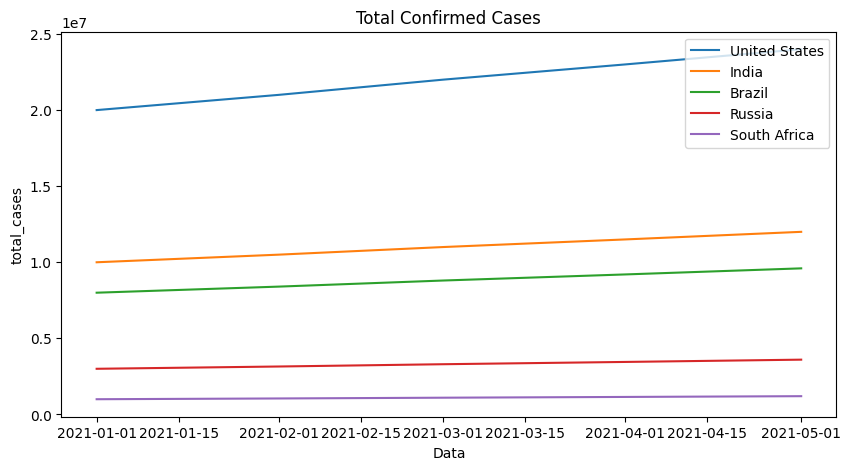

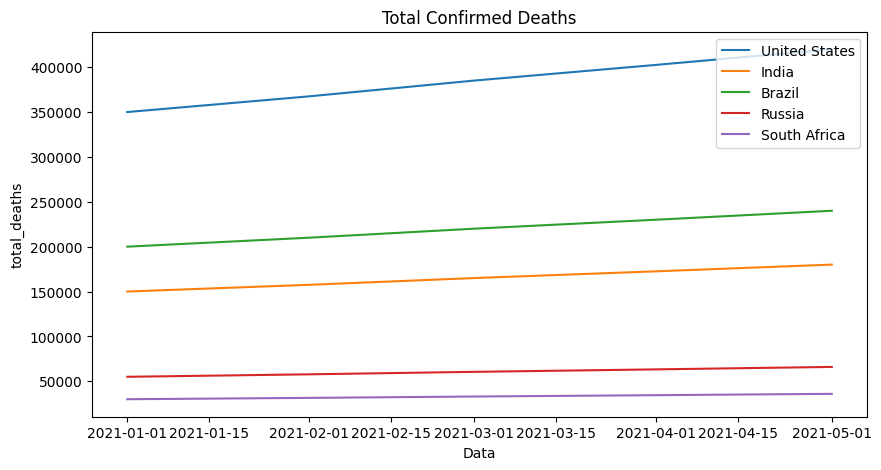

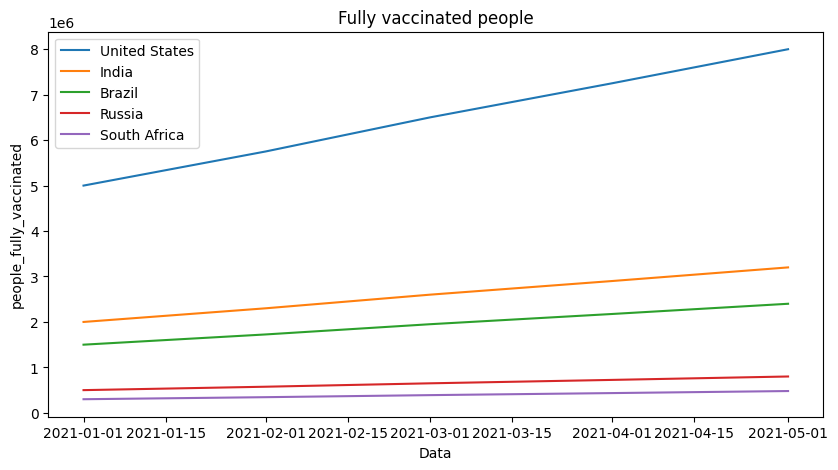

In [5]:

# =========================
# 5) Main charts
# =========================

# Accumulated cases
plot_country_series(df_clean, "total_cases", "Total Confirmed Cases")

# Accumulated deaths
plot_country_series(df_clean, "total_deaths", "Total Confirmed Deaths")

# Vaccination
plot_country_series(df_clean, "people_fully_vaccinated", "Fully vaccinated people")


In [6]:

# =========================
# 6)Top countries on the last day 
# =========================
last_by_country = (
    df_clean.sort_values("date")
    .groupby("location")
    .tail(1)
)

if "total_cases" in last_by_country.columns:
    top_cases = last_by_country.nlargest(10, "total_cases")[["location", "total_cases"]]
    print("\n:Top 10 countries with the most cases")
    print(top_cases)

if "total_deaths" in last_by_country.columns:
    top_deaths = last_by_country.nlargest(10, "total_deaths")[["location", "total_deaths"]]
    print("\n:Top 10 countries with the most deaths")
    print(top_deaths)



:Top 10 countries with the most cases
         location  total_cases
20  United States   24000000.0
21          India   12000000.0
22         Brazil    9600000.0
23         Russia    3600000.0
24   South Africa    1200000.0

:Top 10 countries with the most deaths
         location  total_deaths
20  United States      420000.0
22         Brazil      240000.0
21          India      180000.0
23         Russia       66000.0
24   South Africa       36000.0


In [7]:

# =========================
# 7) Interactive Map (optional with Plotly) 
# =========================
if "total_cases" in last_by_country.columns:
    fig = px.choropleth(
        last_by_country,
        locations="iso_code",
        color="total_cases",
        hover_name="location",
        title="Total Confirmed Cases (last date)",
        color_continuous_scale="Reds"
    )
    fig.show()


In [8]:

# Filter by countries and date range
selected_countries = ["Angola", "Brazil", "India"]  
start_date = "2021-01-01"
end_date = "2021-12-31"

df_filtered = df[
    (df["location"].isin(selected_countries)) &
    (df["date"].between(start_date, end_date))
]

print("Filtered data shape:", df_filtered.shape)
df_filtered.head()


Filtered data shape: (10, 7)


,date,location,iso_code,continent,total_cases,total_deaths,people_fully_vaccinated
1,2021-01-01,India,IND,Asia,10000000.0,150000.0,2000000.0
2,2021-01-01,Brazil,BRA,South America,8000000.0,200000.0,1500000.0
6,2021-02-01,India,IND,Asia,10500000.0,157500.0,2300000.0
7,2021-02-01,Brazil,BRA,South America,8400000.0,210000.0,1725000.0
11,2021-03-01,India,IND,Asia,11000000.0,165000.0,2600000.0


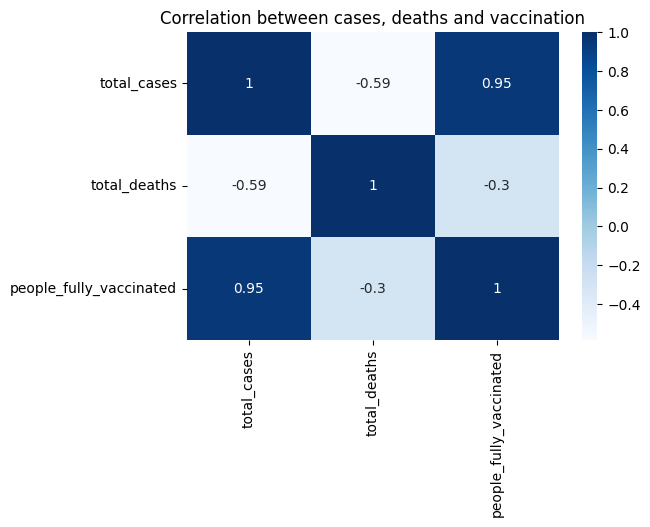

In [9]:

# Correlation heatmap
numeric_cols = ["total_cases", "total_deaths", "people_fully_vaccinated"]
corr = df_filtered[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation between cases, deaths and vaccination")
plt.show()


In [10]:

#  Vaccination pie chart (latest available date)
latest = df_filtered.sort_values("date").groupby("location").tail(1)

for country in selected_countries:
    row = latest[latest["location"] == country]
    if not row.empty and "population" in df.columns:
        total_pop = row["population"].values[0]
        vaccinated = row["people_fully_vaccinated"].values[0]
        not_vaccinated = total_pop - vaccinated
        
        plt.figure(figsize=(4,4))
        plt.pie(
            [vaccinated, not_vaccinated],
            labels=["Vaccinated", "Not vaccinated"],
            autopct="%1.1f%%",
            startangle=90
        )
        plt.title(f"Vaccination in {country}")
        plt.show()


In [11]:

# Export report to PDF (requires reportlab)
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

pdf_path = "covid_report.pdf"
doc = SimpleDocTemplate(pdf_path)
styles = getSampleStyleSheet()
flowables = []

flowables.append(Paragraph("COVID-19 Global Data Tracker", styles['Title']))
flowables.append(Spacer(1, 20))
flowables.append(Paragraph("Key Insights:", styles['Heading2']))

insights = [
    "1. Brazil and India experienced sharp peaks in 2021.",
    "2. Death rates stabilized after the start of vaccinations.",
    "3. Countries with higher vaccination rates showed lower death rates."
]

for i in insights:
    flowables.append(Paragraph(i, styles['Normal']))
    flowables.append(Spacer(1, 10))

doc.build(flowables)
print(f"Report saved to {pdf_path}")


Report saved to covid_report.pdf
